# NLP tf-idf pipeline with cuML + Dask

In [1]:
%matplotlib inline
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait
import dask_cudf
from cuml.feature_extraction.text import HashingVectorizer
from cuml.dask.feature_extraction.text import TfidfTransformer
import nltk
import cupy as cp
from tqdm import tqdm
from utils import SimpleTimer, ResultsLogger, scale_workers
from utils import visualize_data_cuml as visualize_data
import dask

## Setting up the Dask cuda cluster

In [2]:
# # Create a local CUDA cluster
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1,2,3,4,5,6,7", local_directory="./u01/tmp")
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38501,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34417,Total threads: 1
Dashboard: http://127.0.0.1:35089/status,Memory: 125.97 GiB
Nanny: tcp://127.0.0.1:38831,


## Benchmarking Code

### Helper Functions

In [4]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.',
                '/', '\\', ':', ';', '<', '=', '>', '?', '@', '[', ']', '^',
                '_', '`', '{', '|', '}', '\t','\n', "'", ",", '~' , '—']

def read_data(client, parquet_path, benchmark=True):
    data = dask_cudf.read_parquet(parquet_path)
    if benchmark:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
        print(data.shape[0].compute())
    return data


def text_preprocessor(data, client, column_name, PUNCTUATIONS,
                      STOPWORDS, benchmark=True):
    data = data[data[column_name].notnull()]
    data[column_name] = (data[column_name]
                         .str.lower()
                         .str.replace_tokens(
                             PUNCTUATIONS, [" "]*len(PUNCTUATIONS))
                         .str.replace_tokens(STOPWORDS, "")
                         .str.normalize_spaces()
                         .str.strip())
    if benchmark:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
        print(data.shape[0].compute())
    return data


def hashing_vectorizer(data, client, column_name, benchmark):
    vectorizer = HashingVectorizer(stop_words=None, preprocessor=None)
    # Meta is an empty dataframe matches the dtypes and columns of the output
    meta = dask.array.from_array(
        cp.sparse.csr_matrix(cp.zeros(1, dtype=cp.float32)))
    hashing_vectorized = data[column_name].map_partitions(
        vectorizer.fit_transform, meta=meta).astype(cp.float32)
    if benchmark:
        with dask.annotate(workers=set(client.has_what().keys())):
            hashing_vectorized = client.persist(hashing_vectorized)
        wait(hashing_vectorized)
        hashing_vectorized.compute_chunk_sizes()
        print(hashing_vectorized.shape)
    return hashing_vectorized


def tfidf_transformer(data, client, benchmark):
    multi_gpu_transformer = TfidfTransformer()
    result = multi_gpu_transformer.fit_transform(data)
    if benchmark:
        with dask.annotate(workers=set(client.has_what().keys())):
            result = client.persist(result)
        wait(result)
        result.compute_chunk_sizes()
        print(result.shape)
    return result


def execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1],
                            result_path="./results.pkl", benchmark=True):
    sample_record = {"overall": 0, "data_read": 0, "hashing_vectorizer": 0,
                    "tfidf_transformer": 0, "data_preprocessing": 0, "nrows": 0}
    client.restart()
    with SimpleTimer() as timer:
        data = read_data(client, parquet_path, benchmark)
    sample_record["data_read"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        data = text_preprocessor(data, client, "review_body", PUNCTUATIONS, STOPWORDS, benchmark)
    sample_record["data_preprocessing"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data, client, "review_body", benchmark)
    sample_record["hashing_vectorizer"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, client, benchmark=True)
    sample_record["tfidf_transformer"] = timer.elapsed/1e9

    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")

    return data, result, sample_record

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def performance_numbers(client, parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", benchmark=True):
    """
    Main function to perform the performance sweep
    """
    results_logger = ResultsLogger(result_path)
    for n in worker_counts: 
        scale_workers(client, n)
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path=result_path, benchmark=benchmark)
            sample_record["overall"]=overalltimer.elapsed/1e9
            sample_record["nrows"]=data.shape[0].compute()
            sample_record["n_workers"]=n
            sample_record["sample_run"]=i
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed/1e9}s")
            results_logger.log(sample_record)
    results_logger.write()

## Benchmark latency by materializing the intermediate dataframe(s) in every stage

In [6]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [2, 4, 6, 8]
result_path = f"./results/result_poc_nlp_dask_{dataset}_persist.csv"

In [7]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, benchmark=True)

/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:25:29.043681] [Delayed('_merge_stats_to_model-f3725329-3b8f-4beb-ad61-7b83b8971a0d')]
[I] [16:25:29.045991] [Delayed('_merge_stats_to_model-f26b750b-6886-4390-8507-fee1f9419eba')]
[I] [16:25:29.113792] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f3725329-3b8f-4beb-ad61-7b83b8971a0d>]
[I] [16:25:29.113865] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f26b750b-6886-4390-8507-fee1f9419eba>]
[I] [16:25:29.120707] [Delayed('_merge_stats_to_model-dd3fd7f8-7639-4993-95a4-6e9db86f6cb1')]


 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:55<03:40, 55.13s/it]

(20725971, 1048576)
Workers:2, Sample Run:0, Finished loading data in 8.883758639s
Workers:2, Sample Run:0, Finished preprocessing data in 17.852982982s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 21.984687763s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 3.578672746s
Workers:2, Sample Run:0, Finished executing full pipeline in 55.064766322s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:26:20.777204] [Delayed('_merge_stats_to_model-baa23c78-36e5-4a24-bda5-43b29f5cd9e9')]
[I] [16:26:20.779898] [Delayed('_merge_stats_to_model-66d09395-6672-4feb-a95c-6ec6fa4680bb')]
[I] [16:26:20.884311] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-baa23c78-36e5-4a24-bda5-43b29f5cd9e9>]
[I] [16:26:20.884390] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-66d09395-6672-4feb-a95c-6ec6fa4680bb>]
[I] [16:26:20.890641] [Delayed('_merge_stats_to_model-ddc29564-fb42-4b86-83e0-90f81772603c')]


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:46<02:39, 53.15s/it]

(20725971, 1048576)
Workers:2, Sample Run:1, Finished loading data in 5.37510705s
Workers:2, Sample Run:1, Finished preprocessing data in 17.272631007s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 21.666843902s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 3.449423601s
Workers:2, Sample Run:1, Finished executing full pipeline in 51.710654636s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:27:12.444288] [Delayed('_merge_stats_to_model-cc986304-e8cf-4a8f-a605-15fd22809c3e')]
[I] [16:27:12.446336] [Delayed('_merge_stats_to_model-5b9d5241-bcd1-40d3-b814-bc055c6cd3c3')]
[I] [16:27:12.709305] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cc986304-e8cf-4a8f-a605-15fd22809c3e>]
[I] [16:27:12.709591] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-5b9d5241-bcd1-40d3-b814-bc055c6cd3c3>]
[I] [16:27:12.717412] [Delayed('_merge_stats_to_model-aa84bb85-f054-4373-947c-518455fe4dd0')]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [02:40<01:46, 53.48s/it]

(20725971, 1048576)
Workers:2, Sample Run:2, Finished loading data in 5.499514401s
Workers:2, Sample Run:2, Finished preprocessing data in 17.276147259s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 21.908530524s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 5.63539538s
Workers:2, Sample Run:2, Finished executing full pipeline in 53.808349226s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:28:07.890299] [Delayed('_merge_stats_to_model-baac5f73-1ad4-4c12-8105-99bac090b399')]
[I] [16:28:07.892549] [Delayed('_merge_stats_to_model-8101ce5e-6468-4ded-8516-c7fe2a1a48ac')]
[I] [16:28:07.944703] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-baac5f73-1ad4-4c12-8105-99bac090b399>]
[I] [16:28:07.944961] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8101ce5e-6468-4ded-8516-c7fe2a1a48ac>]
[I] [16:28:07.951653] [Delayed('_merge_stats_to_model-d36ff70d-7b02-41e5-9335-2cf71c00531a')]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [03:33<00:53, 53.34s/it]

(20725971, 1048576)
Workers:2, Sample Run:3, Finished loading data in 6.267777424s
Workers:2, Sample Run:3, Finished preprocessing data in 17.288061274s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 20.859937352s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 3.545452127s
Workers:2, Sample Run:3, Finished executing full pipeline in 53.069569032s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:28:58.583404] [Delayed('_merge_stats_to_model-72516648-a832-485b-9aaf-8301e7ab04aa')]
[I] [16:28:58.585523] [Delayed('_merge_stats_to_model-6cfe97a7-b785-4b0c-b394-a5de6355d200')]
[I] [16:28:58.688668] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-72516648-a832-485b-9aaf-8301e7ab04aa>]
[I] [16:28:58.688956] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6cfe97a7-b785-4b0c-b394-a5de6355d200>]
[I] [16:28:58.695602] [Delayed('_merge_stats_to_model-0fc206a5-926c-47a2-b20e-47911fe40b4e')]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:24<00:00, 52.95s/it]

(20725971, 1048576)
Workers:2, Sample Run:4, Finished loading data in 5.421334915s
Workers:2, Sample Run:4, Finished preprocessing data in 17.165412672s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 20.970147577s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 3.440092487s
Workers:2, Sample Run:4, Finished executing full pipeline in 50.787731873s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:29:32.944800] [Delayed('_merge_stats_to_model-55fc9aee-68f8-4f30-a22d-cfd0d06fa70a')]
[I] [16:29:32.945545] [Delayed('_merge_stats_to_model-ea9c615e-2493-4671-a74f-8ad456a6f865')]
[I] [16:29:32.946683] [Delayed('_merge_stats_to_model-c661144d-5ac9-4e78-9704-87b1bede69a9')]
[I] [16:29:32.947993] [Delayed('_merge_stats_to_model-864c39ea-96a7-4d48-b87e-e77fd315e874')]
[I] [16:29:32.985656] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-55fc9aee-68f8-4f30-a22d-cfd0d06fa70a>]
[I] [16:29:32.985885] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ea9c615e-2493-4671-a74f-8ad456a6f865>]
[I] [16:29:32.986015] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c661144d-5ac9-4e78-9704-87b1bede69a9>]
[I] [16:29:32.986152] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-864c39ea-96a7-4d48-b87e-e77fd315e874>]
[I] [16:29:33.003710] [Delaye

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:29<01:56, 29.10s/it]

(20725971, 1048576)
Workers:4, Sample Run:0, Finished loading data in 3.179698737s
Workers:4, Sample Run:0, Finished preprocessing data in 9.187715427s
Workers:4, Sample Run:0, Finished fitting HashVectorizer in 10.561659775s
Workers:4, Sample Run:0, Finished fitting IDF Transformer in 2.45680928s
Workers:4, Sample Run:0, Finished executing full pipeline in 29.045028326s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:30:02.324389] [Delayed('_merge_stats_to_model-f2daf7d8-a4c0-468f-a042-f0f4a64f3ba6')]
[I] [16:30:02.325739] [Delayed('_merge_stats_to_model-4483cb42-caa8-4836-b6ca-41e6c7f6ceea')]
[I] [16:30:02.326435] [Delayed('_merge_stats_to_model-d98959fe-7c82-40f0-92e3-6ef72b7fade0')]
[I] [16:30:02.327104] [Delayed('_merge_stats_to_model-627fe143-9138-489c-b0f4-c4c0c963bc43')]
[I] [16:30:02.364928] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f2daf7d8-a4c0-468f-a042-f0f4a64f3ba6>]
[I] [16:30:02.365142] [<Future: finished, type: cuml.TfidfTransfor

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [00:58<01:27, 29.31s/it]

(20725971, 1048576)
Workers:4, Sample Run:1, Finished loading data in 3.036154087s
Workers:4, Sample Run:1, Finished preprocessing data in 9.147149558s
Workers:4, Sample Run:1, Finished fitting HashVectorizer in 10.581339864s
Workers:4, Sample Run:1, Finished fitting IDF Transformer in 2.502018069s
Workers:4, Sample Run:1, Finished executing full pipeline in 29.399143574s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:30:33.046464] [Delayed('_merge_stats_to_model-621383ae-2c81-4128-b719-8548c80e0e45')]
[I] [16:30:33.047837] [Delayed('_merge_stats_to_model-b1c7d781-1387-49f0-9045-1443e02c8ac0')]
[I] [16:30:33.048476] [Delayed('_merge_stats_to_model-6a0725c9-6902-4ac9-a8e9-b41d1811c5be')]
[I] [16:30:33.049130] [Delayed('_merge_stats_to_model-b0360824-8f7b-44a7-b45c-b40d7bd7d987')]
[I] [16:30:33.088425] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-621383ae-2c81-4128-b719-8548c80e0e45>]
[I] [16:30:33.088659] [<Future: finished, type: cuml.TfidfTransfo

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:29<00:59, 29.96s/it]

(20725971, 1048576)
Workers:4, Sample Run:2, Finished loading data in 3.087933581s
Workers:4, Sample Run:2, Finished preprocessing data in 10.143229468s
Workers:4, Sample Run:2, Finished fitting HashVectorizer in 10.598026344s
Workers:4, Sample Run:2, Finished fitting IDF Transformer in 2.545099485s
Workers:4, Sample Run:2, Finished executing full pipeline in 30.681655427s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:31:02.726759] [Delayed('_merge_stats_to_model-894fc410-5fe7-4815-bcf2-23117769ab61')]
[I] [16:31:02.728226] [Delayed('_merge_stats_to_model-6ecf0961-98dd-4729-90fa-e4a678af9b5c')]
[I] [16:31:02.729581] [Delayed('_merge_stats_to_model-ddb724f8-d107-48bb-a055-1490e249976b')]
[I] [16:31:02.730263] [Delayed('_merge_stats_to_model-a037d666-0fcb-4640-be47-d15d800eae38')]
[I] [16:31:02.772223] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-894fc410-5fe7-4815-bcf2-23117769ab61>]
[I] [16:31:02.772459] [<Future: finished, type: cuml.TfidfTransf

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [01:58<00:29, 29.81s/it]

(20725971, 1048576)
Workers:4, Sample Run:3, Finished loading data in 3.154278374s
Workers:4, Sample Run:3, Finished preprocessing data in 9.166676002s
Workers:4, Sample Run:3, Finished fitting HashVectorizer in 10.74899429s
Workers:4, Sample Run:3, Finished fitting IDF Transformer in 2.422896941s
Workers:4, Sample Run:3, Finished executing full pipeline in 29.517265322s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:31:34.943094] [Delayed('_merge_stats_to_model-9b229dde-8a08-41df-902f-e1ec67bf3a89')]
[I] [16:31:34.944314] [Delayed('_merge_stats_to_model-5feaccf6-8059-4c15-b9aa-1dcf868d48fb')]
[I] [16:31:34.945018] [Delayed('_merge_stats_to_model-ea61a899-accd-4ff9-9e05-5243a237faa0')]
[I] [16:31:34.945753] [Delayed('_merge_stats_to_model-c0032c9e-efb2-499b-9616-45408d4a286b')]
[I] [16:31:34.984832] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9b229dde-8a08-41df-902f-e1ec67bf3a89>]
[I] [16:31:34.984904] [<Future: finished, type: cuml.TfidfTransfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.20s/it]

(20725971, 1048576)
Workers:4, Sample Run:4, Finished loading data in 3.07736164s
Workers:4, Sample Run:4, Finished preprocessing data in 10.468178192s
Workers:4, Sample Run:4, Finished fitting HashVectorizer in 10.834976649s
Workers:4, Sample Run:4, Finished fitting IDF Transformer in 2.385658513s
Workers:4, Sample Run:4, Finished executing full pipeline in 32.057054428s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:32:13.845417] [Delayed('_merge_stats_to_model-6a6c5a8c-c22e-49c5-969b-38ee8e485be6')]
[I] [16:32:13.846190] [Delayed('_merge_stats_to_model-6c1b362a-0aea-4716-9004-bdf82137dee9')]
[I] [16:32:13.846464] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-252ade97-d54b-475a-804e-df519f011758>]
[I] [16:32:13.846796] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-24c145d0-4e51-4391-bac6-6d40572aaf26>]
[I] [16:32:13.847482] [Delayed('_merge_stats_to_model-bcf791f8-f29a-4404-b500-f8fdfbc6d77f')]
[I] [16:32:13.848223] [Delayed('_merge_stats_to_model-008e883e-53a9-4a63-87c3-7dd95707a83a')]
[I] [16:32:13.874769] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6a6c5a8c-c22e-49c5-969b-38ee8e485be6>]
[I] [16:32:13.874864] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6c1b362a-0aea-4716-9004-bdf82137dee9>]
[I] [16:32:13.875144] [<Future: finished, t

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:33<02:15, 33.99s/it]

(20725971, 1048576)
Workers:6, Sample Run:0, Finished loading data in 3.129406279s
Workers:6, Sample Run:0, Finished preprocessing data in 15.666365508s
Workers:6, Sample Run:0, Finished fitting HashVectorizer in 8.117589141s
Workers:6, Sample Run:0, Finished fitting IDF Transformer in 2.370302062s
Workers:6, Sample Run:0, Finished executing full pipeline in 33.932259072s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:32:39.213558] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-8adda9b3-eaa1-4f19-a2be-6614ddf9deca>]
[I] [16:32:39.214468] [Delayed('_merge_stats_to_model-3639b69a-abc1-4063-b6a3-a7ba7065e7a6')]
[I] [16:32:39.215184] [Delayed('_merge_stats_to_model-6ddf194c-8a43-46c9-8bda-86e761f613fe')]
[I] [16:32:39.215859] [Delayed('_merge_stats_to_model-5c14c301-a5b2-4380-9c0a-ff6de78fa9e9')]
[I] [16:32:39.216063] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-c7313267-f34b-4955-ad10-9cdea22c88a5>]
[I] [16:32:39.216701] [Delayed('_merge_stats_to_model-8086a7cc-1c48-4618-9cd5-51d14020b8aa')]
[I] [16:32:39.248936] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-8adda9b3-eaa1-4f19-a2be-6614ddf9deca>]
[I] [16:32:39.249502] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3639b69a-abc1-4063-b6a3-a7ba7065e7a6>]
[I] [16:32:39.249647] [<Future: finished, type: cu

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [00:59<01:26, 28.91s/it]

(20725971, 1048576)
Workers:6, Sample Run:1, Finished loading data in 2.864376021s
Workers:6, Sample Run:1, Finished preprocessing data in 7.07918496s
Workers:6, Sample Run:1, Finished fitting HashVectorizer in 8.036034759s
Workers:6, Sample Run:1, Finished fitting IDF Transformer in 2.380518389s
Workers:6, Sample Run:1, Finished executing full pipeline in 25.298685357s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:33:05.153187] [Delayed('_merge_stats_to_model-f5665f42-23ea-4590-be52-761e3ba92002')]
[I] [16:33:05.154070] [Delayed('_merge_stats_to_model-7989ee19-fe75-4e7c-b390-e886f7aa5209')]
[I] [16:33:05.154792] [Delayed('_merge_stats_to_model-c9c1101b-5e19-4d05-b555-29fa33eb0973')]
[I] [16:33:05.155046] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-93e7b7df-43be-4874-8044-beb80f98095c>]
[I] [16:33:05.155206] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-65c0d74d-819e-4282-b01f-b0bfcf2d4c8b>]
[I] [16:33:05.155923] [Delayed('_merge

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:25<00:55, 27.58s/it]

(20725971, 1048576)
Workers:6, Sample Run:2, Finished loading data in 3.02086784s
Workers:6, Sample Run:2, Finished preprocessing data in 7.12860546s
Workers:6, Sample Run:2, Finished fitting HashVectorizer in 8.231666516s
Workers:6, Sample Run:2, Finished fitting IDF Transformer in 2.545348986s
Workers:6, Sample Run:2, Finished executing full pipeline in 25.945662511s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:33:30.635881] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-19be4c33-ea5c-460f-a8f6-dece430be883>]
[I] [16:33:30.636208] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-42dc24ab-ecad-4a6a-810e-fb1eb53f58c2>]
[I] [16:33:30.636936] [Delayed('_merge_stats_to_model-957ae1d4-5908-42bd-b211-f4ca6613e3c0')]
[I] [16:33:30.638270] [Delayed('_merge_stats_to_model-c6dbb905-82a0-46b8-bfb7-e4a353ce7356')]
[I] [16:33:30.638992] [Delayed('_merge_stats_to_model-a33a1d89-ce58-4bae-9914-a3722dc050f3')]
[I] [16:33:30.639730] [Delayed('_merge_

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [01:50<00:26, 26.72s/it]

(20725971, 1048576)
Workers:6, Sample Run:3, Finished loading data in 3.108468884s
Workers:6, Sample Run:3, Finished preprocessing data in 7.067627547s
Workers:6, Sample Run:3, Finished fitting HashVectorizer in 8.077568644s
Workers:6, Sample Run:3, Finished fitting IDF Transformer in 2.389773346s
Workers:6, Sample Run:3, Finished executing full pipeline in 25.356369877s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:33:56.404802] [Delayed('_merge_stats_to_model-fea49756-0797-48ae-966b-339b758466e9')]
[I] [16:33:56.405718] [Delayed('_merge_stats_to_model-56526c5f-83c2-46f2-bddc-f489910a6147')]
[I] [16:33:56.405945] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ff87e735-5dcd-4099-949d-741531a1e381>]
[I] [16:33:56.406570] [Delayed('_merge_stats_to_model-c4c00fb5-ce3c-4333-9753-c2bdf3d24563')]
[I] [16:33:56.407261] [Delayed('_merge_stats_to_model-027c2192-3286-446d-a20f-1131dd34017c')]
[I] [16:33:56.407469] [<Future: finished, type: cuml.TfidfTransformer, ke

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]

(20725971, 1048576)
Workers:6, Sample Run:4, Finished loading data in 2.978817336s
Workers:6, Sample Run:4, Finished preprocessing data in 7.178252203s
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 8.169877245s
Workers:6, Sample Run:4, Finished fitting IDF Transformer in 2.233386452s
Workers:6, Sample Run:4, Finished executing full pipeline in 25.609932109s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:34:27.002711] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-04cc911c-5a45-427a-97be-96f139b5f6fc>]
[I] [16:34:27.003002] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ef6b67a0-7dd2-49dd-acf5-b8ea61e58e37>]
[I] [16:34:27.003130] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6f0f804f-e30c-4c09-8d10-bed37e014571>]
[I] [16:34:27.003265] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e2431fae-7a58-4331-832c-c5247820723f>]
[I] [16:34:27.004196] [Delayed('_merge_stats_to_model-cd3957aa-8867-4b67-946f-dc7867214065')]
[I] [16:34:27.004420] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b6d06514-f4b2-49ac-a2b0-10af08bbce89>]
[I] [16:34:27.004569] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9c7b0ed1-64cd-4482-ac87-de3e94189363>]
[I] [16:34:27.005158] [Delayed('_merge_stats_to_model-67d499ae-485a-4ae6-b35b-2

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:25<01:41, 25.44s/it]

(20725971, 1048576)
Workers:8, Sample Run:0, Finished loading data in 3.0755377s
Workers:8, Sample Run:0, Finished preprocessing data in 6.31151694s
Workers:8, Sample Run:0, Finished fitting HashVectorizer in 8.142951325s
Workers:8, Sample Run:0, Finished fitting IDF Transformer in 2.225794135s
Workers:8, Sample Run:0, Finished executing full pipeline in 25.380315272s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:34:52.586376] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e9bd1039-f819-4e78-822b-29acf74a9aab>]
[I] [16:34:52.586669] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-417376bf-078b-4e25-aa9f-a9620e5171f3>]
[I] [16:34:52.587350] [Delayed('_merge_stats_to_model-901886c4-453a-4521-b7cf-d90a4bca4866')]
[I] [16:34:52.587580] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b27b72ec-e574-4397-afbd-9a4fd0b6e083>]
[I] [16:34:52.588177] [Delayed('_merge_stats_to_model-5459c194-eb99-4980-ad85-92da0fd1a64c')]
[I] [16:34:52.588275] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-315d06df-1978-45c7-a24a-ccf46ffec836>]
[I] [16:34:52.588324] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-66d0bcab-93b3-4f1c-a4f0-ca47c74f322d>]
[I] [16:34:52.588366] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-bb680580-d019-4d07-ab8b-

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [00:51<01:16, 25.60s/it]

(20725971, 1048576)
Workers:8, Sample Run:1, Finished loading data in 3.155098701s
Workers:8, Sample Run:1, Finished preprocessing data in 6.369129066s
Workers:8, Sample Run:1, Finished fitting HashVectorizer in 8.173860263s
Workers:8, Sample Run:1, Finished fitting IDF Transformer in 2.352708403s
Workers:8, Sample Run:1, Finished executing full pipeline in 25.654391349s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:35:18.025699] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b0f018f4-c7bb-4a39-a7ce-699c5ab49aa3>]
[I] [16:35:18.026038] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-46cd592f-1a71-4262-9d5d-611014a9f40c>]
[I] [16:35:18.026168] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-81be0eca-163e-471d-b9aa-741910b60654>]
[I] [16:35:18.026289] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-cc8052d5-002a-4ab8-86f7-c928d17aeea4>]
[I] [16:35:18.027037] [Delayed('_merge_stats_to_model-3d267

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:16<00:50, 25.50s/it]

(20725971, 1048576)
Workers:8, Sample Run:2, Finished loading data in 2.907258793s
Workers:8, Sample Run:2, Finished preprocessing data in 6.352804184s
Workers:8, Sample Run:2, Finished fitting HashVectorizer in 8.208038369s
Workers:8, Sample Run:2, Finished fitting IDF Transformer in 2.28923333s
Workers:8, Sample Run:2, Finished executing full pipeline in 25.328898947s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:35:44.650558] [Delayed('_merge_stats_to_model-18ebf19b-4500-4484-a8f2-e46cfb2364cf')]
[I] [16:35:44.651563] [Delayed('_merge_stats_to_model-8b1a8769-e56d-4375-81be-43981881be5b')]
[I] [16:35:44.651848] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-71ed8a93-9d97-48e8-b12f-aaaecc3ae815>]
[I] [16:35:44.651986] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6297bee8-0b03-441b-b9ab-b4c794ee3c1e>]
[I] [16:35:44.652111] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-06d09263-eba1-4baa-bc29-93ab6432f47f>]
[I

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [01:43<00:25, 25.97s/it]

(20725971, 1048576)
Workers:8, Sample Run:3, Finished loading data in 2.957846586s
Workers:8, Sample Run:3, Finished preprocessing data in 7.18190727s
Workers:8, Sample Run:3, Finished fitting HashVectorizer in 8.288011795s
Workers:8, Sample Run:3, Finished fitting IDF Transformer in 2.483243726s
Workers:8, Sample Run:3, Finished executing full pipeline in 26.63417415s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [16:36:10.249864] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-7438cce8-ee5b-4372-9ffb-f30b8bea3b9a>]
[I] [16:36:10.250989] [Delayed('_merge_stats_to_model-b43d27fb-ef4b-4b25-89a1-481b50b8f8c1')]
[I] [16:36:10.251232] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9808a6c4-6692-4104-b5bf-65d45200d5ca>]
[I] [16:36:10.251375] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-df8b3df5-3119-4355-8c01-af05b097b6b8>]
[I] [16:36:10.251584] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-f571ad

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]

(20725971, 1048576)
Workers:8, Sample Run:4, Finished loading data in 3.003960848s
Workers:8, Sample Run:4, Finished preprocessing data in 6.377659547s
Workers:8, Sample Run:4, Finished fitting HashVectorizer in 8.251389726s
Workers:8, Sample Run:4, Finished fitting IDF Transformer in 2.461905514s
Workers:8, Sample Run:4, Finished executing full pipeline in 25.661763307s
CPU times: user 30.3 s, sys: 16.5 s, total: 46.8 s
Wall time: 11min 41s


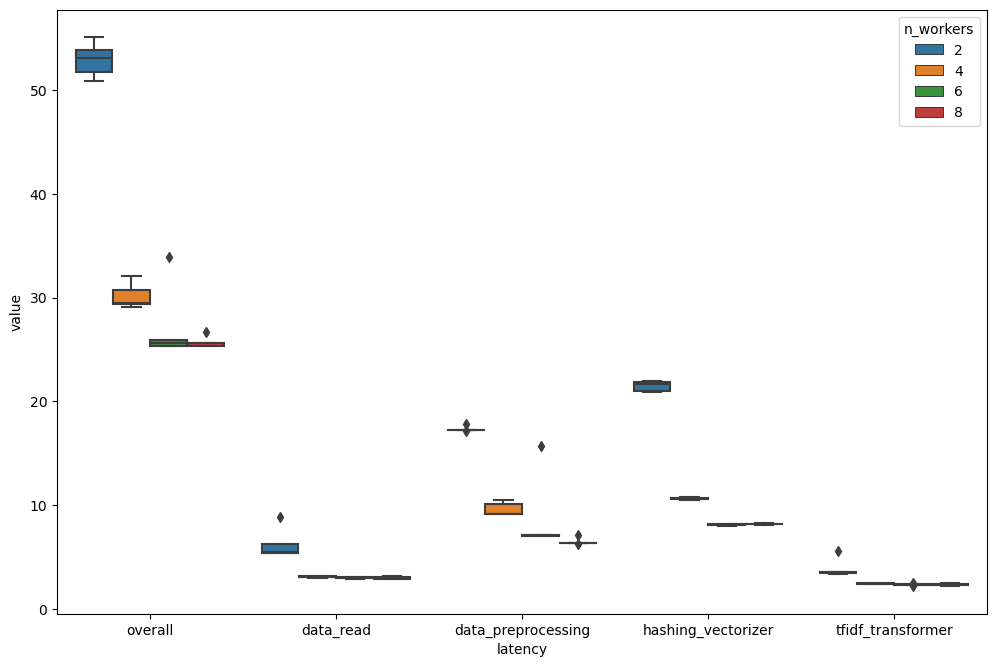

In [8]:
data, melt_data = visualize_data(result_path)        

In [9]:
groupby = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupby

Unnamed: 0                    overall                 data_read  \
                mean       std count       mean       std count      mean   
n_workers                                                                   
2                  2  1.581139     5  52.888214  1.689348     5  6.289498   
4                  7  1.581139     5  30.140029  1.235326     5  3.107085   
6                 12  1.581139     5  27.228582  3.756157     5  3.020387   
8                 17  1.581139     5  25.731909  0.527031     5  3.019941   

                          hashing_vectorizer  ... tfidf_transformer  \
                std count               mean  ...             count   
n_workers                                     ...                     
2          1.495372     5          21.478029  ...                 5   
4          0.058697     5          10.664999  ...                 5   
6          0.106901     5           8.126547  ...                 5   
8          0.097682     5           8.212850  ...                 5   

          data_preprocessing                     nrows            sample_run  \
                        mean       std count      mean  std count       mean   
n_workers                                                                      
2                  17.371047  0.273919     5  20725971  0.0     5          2   
4                   9.622590  0.634252     5  20725971  0.0     5          2   
6                   8.824007  3.825246     5  20725971  0.0     5          2   
8                   6.518603  0.371670     5  20725971  0.0     5          2   

                           
                std count  
n_workers                  
2          1.581139     5  
4          1.581139     5  
6          1.581139     5  
8          1.581139     5  

[4 rows x 24 columns]

## Benchmark latency without materializing the intermediate dataframe(s) except for the last stage

In [11]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 5
worker_counts = [2, 4, 6, 8]
result_path = f"./results/result_poc_nlp_dask_{dataset}_nonpersist.csv"

In [12]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, benchmark=False)

/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

# nnz: 0
[I] [16:37:06.606917] [Delayed('_merge_stats_to_model-9f7d913c-fdca-4d04-95e6-0f74fd08eac4')]
[I] [16:37:06.609233] [Delayed('_merge_stats_to_model-a852e37a-224a-4450-8c51-56cf76b452fc')]
[I] [16:37:06.685675] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9f7d913c-fdca-4d04-95e6-0f74fd08eac4>]
[I] [16:37:06.685905] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a852e37a-224a-4450-8c51-56cf76b452fc>]
[I] [16:37:06.691424] [Delayed('_merge_stats_to_model-51f4435d-5a29-475c-a24c-ec4097cab604')]
(20725971, 1048576)
Workers:2, Sample Run:0, Finished loading data in 0.01871742s
Workers:2, Sample Run:0, Finished preprocessing data in 0.024172099s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 0.003483583s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 91.262564019s


 20%|██████████████████████████████████▌                                                                                                                                          | 1/5 [01:56<07:44, 116.22s/it]

Workers:2, Sample Run:0, Finished executing full pipeline in 94.672536457s
# nnz: 0
[I] [16:39:06.178562] [Delayed('_merge_stats_to_model-e3d4d175-c1f8-4eed-bad1-b5ccf5c5e23d')]
[I] [16:39:06.180964] [Delayed('_merge_stats_to_model-1dbc2c53-0e9e-4710-ae50-a19758f79989')]
[I] [16:39:06.251969] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e3d4d175-c1f8-4eed-bad1-b5ccf5c5e23d>]
[I] [16:39:06.252201] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1dbc2c53-0e9e-4710-ae50-a19758f79989>]
[I] [16:39:06.257690] [Delayed('_merge_stats_to_model-a4a4eab4-d077-43c4-8b46-ce7626243515')]
(20725971, 1048576)
Workers:2, Sample Run:1, Finished loading data in 0.018594426s
Workers:2, Sample Run:1, Finished preprocessing data in 0.021912536s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 0.003504001s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 86.912604217s


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 2/5 [03:50<05:45, 115.31s/it]

Workers:2, Sample Run:1, Finished executing full pipeline in 92.404839702s
# nnz: 0
[I] [16:41:01.459367] [Delayed('_merge_stats_to_model-191d7c8d-5b67-4a12-a498-42d3dbe000c3')]
[I] [16:41:01.461567] [Delayed('_merge_stats_to_model-afaca27d-9870-4c6c-a974-89bb4bd722f6')]
[I] [16:41:01.893393] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-191d7c8d-5b67-4a12-a498-42d3dbe000c3>]
[I] [16:41:01.893707] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-afaca27d-9870-4c6c-a974-89bb4bd722f6>]
[I] [16:41:01.899632] [Delayed('_merge_stats_to_model-5926c2dd-adf4-4d40-b933-879812e92f79')]
(20725971, 1048576)
Workers:2, Sample Run:2, Finished loading data in 0.01994251s
Workers:2, Sample Run:2, Finished preprocessing data in 0.022582113s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 0.003744019s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 89.096830665s


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 3/5 [05:47<03:52, 116.00s/it]

Workers:2, Sample Run:2, Finished executing full pipeline in 95.295359012s
# nnz: 0
[I] [16:43:00.995441] [Delayed('_merge_stats_to_model-07725029-f1cb-4e0a-b4b7-58cafec24f72')]
[I] [16:43:00.997622] [Delayed('_merge_stats_to_model-02fb06b0-6d29-4f95-98ce-b93fe4a0a1a7')]
[I] [16:43:01.127621] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-07725029-f1cb-4e0a-b4b7-58cafec24f72>]
[I] [16:43:01.127925] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-02fb06b0-6d29-4f95-98ce-b93fe4a0a1a7>]
[I] [16:43:01.136336] [Delayed('_merge_stats_to_model-944242cf-5816-4604-aa98-92864e7356be')]
(20725971, 1048576)
Workers:2, Sample Run:3, Finished loading data in 0.024577298s
Workers:2, Sample Run:3, Finished preprocessing data in 0.023766734s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 0.004166832s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 87.958744302s


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4/5 [07:45<01:56, 116.62s/it]

Workers:2, Sample Run:3, Finished executing full pipeline in 96.23971093s
# nnz: 0
[I] [16:44:56.562613] [Delayed('_merge_stats_to_model-2527da6b-828b-40c4-9ea9-ee1aa1e7e450')]
[I] [16:44:56.564738] [Delayed('_merge_stats_to_model-ac959d0e-6caa-4d42-bd33-355a6569ed2c')]
[I] [16:44:56.630966] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2527da6b-828b-40c4-9ea9-ee1aa1e7e450>]
[I] [16:44:56.631152] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ac959d0e-6caa-4d42-bd33-355a6569ed2c>]
[I] [16:44:56.636929] [Delayed('_merge_stats_to_model-a7ccbe26-4b51-4db6-b956-52aa4e330bbe')]
(20725971, 1048576)
Workers:2, Sample Run:4, Finished loading data in 0.020643228s
Workers:2, Sample Run:4, Finished preprocessing data in 0.024553197s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 0.00405205s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 93.969176868s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:47<00:00, 117.59s/it]

Workers:2, Sample Run:4, Finished executing full pipeline in 100.828453805s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


# nnz: 0
[I] [16:46:43.669753] [Delayed('_merge_stats_to_model-c8272617-513f-4c19-a5d7-d2c83e46c9e8')]
[I] [16:46:43.670704] [Delayed('_merge_stats_to_model-0dc512a7-97e1-436f-97bc-4cdff7213833')]
[I] [16:46:43.671419] [Delayed('_merge_stats_to_model-b0a3dd05-076e-496e-ac48-8de5bf78f096')]
[I] [16:46:43.672634] [Delayed('_merge_stats_to_model-e1cae047-701e-4f71-aece-2dc9662da03e')]
[I] [16:46:43.711421] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c8272617-513f-4c19-a5d7-d2c83e46c9e8>]
[I] [16:46:43.711681] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0dc512a7-97e1-436f-97bc-4cdff7213833>]
[I] [16:46:43.711870] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b0a3dd05-076e-496e-ac48-8de5bf78f096>]
[I] [16:46:43.711988] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e1cae047-701e-4f71-aece-2dc9662da03e>]
[I] [16:46:43.718176] [Delayed('_merge_stats_to_model-66bbb612-0c25

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [01:02<04:10, 62.60s/it]

Workers:4, Sample Run:0, Finished executing full pipeline in 51.862553654s
# nnz: 0
[I] [16:47:46.997363] [Delayed('_merge_stats_to_model-76a7275f-cb00-4273-9f19-f121a8627faf')]
[I] [16:47:46.998254] [Delayed('_merge_stats_to_model-9d3f8680-9e70-4ef0-a41f-48005f080b5d')]
[I] [16:47:46.999618] [Delayed('_merge_stats_to_model-526db1da-8315-4938-95fc-6f7292a6dfbe')]
[I] [16:47:47.000861] [Delayed('_merge_stats_to_model-9c52e34b-94a2-4498-8775-c79f4f9ee500')]
[I] [16:47:47.037198] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-76a7275f-cb00-4273-9f19-f121a8627faf>]
[I] [16:47:47.037428] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9d3f8680-9e70-4ef0-a41f-48005f080b5d>]
[I] [16:47:47.037574] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-526db1da-8315-4938-95fc-6f7292a6dfbe>]
[I] [16:47:47.037741] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9c52e34b-94a2-4498-8775-c79f4f9

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [02:02<03:03, 61.06s/it]

Workers:4, Sample Run:1, Finished executing full pipeline in 49.173822578s
# nnz: 0
[I] [16:48:47.803294] [Delayed('_merge_stats_to_model-9105b5c6-c6f1-45c5-8b71-ffed46056918')]
[I] [16:48:47.804176] [Delayed('_merge_stats_to_model-a64793b6-af6b-4951-ad78-c966162466ae')]
[I] [16:48:47.804971] [Delayed('_merge_stats_to_model-9ffe3a9a-c29e-4c04-9140-589736f3cbdb')]
[I] [16:48:47.806225] [Delayed('_merge_stats_to_model-b52fce71-09b5-4a89-84b9-c9dada63d23b')]
[I] [16:48:47.844216] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9105b5c6-c6f1-45c5-8b71-ffed46056918>]
[I] [16:48:47.844418] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a64793b6-af6b-4951-ad78-c966162466ae>]
[I] [16:48:47.844570] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9ffe3a9a-c29e-4c04-9140-589736f3cbdb>]
[I] [16:48:47.844705] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b52fce71-09b5-4a89-84b9-c9dada6

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [03:03<02:01, 60.89s/it]

Workers:4, Sample Run:2, Finished executing full pipeline in 49.702358776s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


# nnz: 0
[I] [16:49:46.795738] [Delayed('_merge_stats_to_model-1da0f934-f3f2-4b52-b0aa-18518ef7b675')]
[I] [16:49:46.797272] [Delayed('_merge_stats_to_model-5d8565ad-bb3e-4595-8b7b-1d7774b5bb94')]
[I] [16:49:46.797962] [Delayed('_merge_stats_to_model-94b9b7f4-dda7-45e4-a2e8-5bdd30c6e882')]
[I] [16:49:46.798692] [Delayed('_merge_stats_to_model-e1f737e1-5220-43f1-b984-12e44fb4fa27')]
[I] [16:49:46.837173] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1da0f934-f3f2-4b52-b0aa-18518ef7b675>]
[I] [16:49:46.837404] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-5d8565ad-bb3e-4595-8b7b-1d7774b5bb94>]
[I] [16:49:46.837535] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-94b9b7f4-dda7-45e4-a2e8-5bdd30c6e882>]
[I] [16:49:46.837658] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e1f737e1-5220-43f1-b984-12e44fb4fa27>]
[I] [16:49:46.844131] [Delayed('_merge_stats_to_model-59ee84b1-4d66

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [04:02<01:00, 60.15s/it]

Workers:4, Sample Run:3, Finished executing full pipeline in 48.25305716s
# nnz: 0
[I] [16:50:46.390903] [Delayed('_merge_stats_to_model-f48bf521-beb5-486c-a043-ac96081ca3af')]
[I] [16:50:46.391846] [Delayed('_merge_stats_to_model-2d245ed4-9e96-4e0a-877b-f280cbddf4bf')]
[I] [16:50:46.393072] [Delayed('_merge_stats_to_model-623ba2fe-57ab-4ea3-bbd3-ce26ab9aba0d')]
[I] [16:50:46.393838] [Delayed('_merge_stats_to_model-ddde4730-237a-4abf-97cf-4817e600c837')]
[I] [16:50:46.432580] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f48bf521-beb5-486c-a043-ac96081ca3af>]
[I] [16:50:46.433047] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2d245ed4-9e96-4e0a-877b-f280cbddf4bf>]
[I] [16:50:46.433209] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-623ba2fe-57ab-4ea3-bbd3-ce26ab9aba0d>]
[I] [16:50:46.433263] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ddde4730-237a-4abf-97cf-4817e600

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:01<00:00, 60.35s/it]

Workers:4, Sample Run:4, Finished executing full pipeline in 48.760858626s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


# nnz: 0
[I] [16:51:45.136215] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4bcf63fa-1787-4d69-a5d5-1cc96d3f07a6>]
[I] [16:51:45.137434] [Delayed('_merge_stats_to_model-bdc0e864-4d25-47e2-951b-6759a3ec9777')]
[I] [16:51:45.137658] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1936fa5e-5e0c-4deb-bfdf-18519ca604b5>]
[I] [16:51:45.138303] [Delayed('_merge_stats_to_model-b9244de8-0070-44eb-80d4-ab87d9ca05d5')]
[I] [16:51:45.139017] [Delayed('_merge_stats_to_model-dc36a884-51b4-47ae-b48d-f460cbc9c4c7')]
[I] [16:51:45.139761] [Delayed('_merge_stats_to_model-7bbccd4f-8256-4e26-8a66-eee3b0fa5c51')]
[I] [16:51:45.183745] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4bcf63fa-1787-4d69-a5d5-1cc96d3f07a6>]
[I] [16:51:45.184029] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-bdc0e864-4d25-47e2-951b-6759a3ec9777>]
[I] [16:51:45.184200] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_sta

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:44<02:58, 44.73s/it]

Workers:6, Sample Run:0, Finished executing full pipeline in 36.455091158s
# nnz: 0
[I] [16:52:29.754183] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-abc43d3b-22ac-46cf-9779-02fad907bf9c>]
[I] [16:52:29.755295] [Delayed('_merge_stats_to_model-852598a5-a842-467f-9d0a-3e1cd7411fd4')]
[I] [16:52:29.755998] [Delayed('_merge_stats_to_model-be7a10ca-92db-442a-85e2-e41e1a0c3dd1')]
[I] [16:52:29.756681] [Delayed('_merge_stats_to_model-720305b4-7353-42ae-8f92-ef69220f50f2')]
[I] [16:52:29.757476] [Delayed('_merge_stats_to_model-889b0b0c-359b-4f41-9d8c-4da0e22329e6')]
[I] [16:52:29.757756] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6321adc3-27a2-42d1-94ac-1c049a2856ed>]
[I] [16:52:29.782757] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-abc43d3b-22ac-46cf-9779-02fad907bf9c>]
[I] [16:52:29.782989] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-852598a5-a842-467f-9d0a-3e1cd7411fd4>]
[I] [16:52:29

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:28<02:12, 44.20s/it]

Workers:6, Sample Run:1, Finished executing full pipeline in 36.25704822s
# nnz: 0
[I] [16:53:13.841551] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-15902852-9ab5-44ca-b47e-6893b6bdb030>]
[I] [16:53:13.842624] [Delayed('_merge_stats_to_model-d6e8ae93-2de6-4231-a34c-edfa870caaef')]
[I] [16:53:13.843360] [Delayed('_merge_stats_to_model-bfd6e569-83df-4ea2-b1bc-912e649aad17')]
[I] [16:53:13.844079] [Delayed('_merge_stats_to_model-8807162a-4e4b-4f52-88bc-3a08e4fbe520')]
[I] [16:53:13.844344] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-50c6f972-d253-42e9-ab9e-e56c99ed2c97>]
[I] [16:53:13.844955] [Delayed('_merge_stats_to_model-f154f854-c486-48b4-a19c-5ef3195b6c70')]
[I] [16:53:13.867296] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-15902852-9ab5-44ca-b47e-6893b6bdb030>]
[I] [16:53:13.867553] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d6e8ae93-2de6-4231-a34c-edfa870caaef>]
[I] [16:53:13.

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [02:17<01:32, 46.35s/it]

Workers:6, Sample Run:2, Finished executing full pipeline in 36.891404242s
# nnz: 0
[I] [16:54:02.461767] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b4cd7241-d984-4cb4-ab0b-f2f62c98dc83>]
[I] [16:54:02.461964] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d19cfc9c-7eae-4458-9427-8e2df364fa16>]
[I] [16:54:02.463067] [Delayed('_merge_stats_to_model-da8da464-afd9-4766-a2da-07d9f194af74')]
[I] [16:54:02.463820] [Delayed('_merge_stats_to_model-aa4ef367-3934-4d65-b386-f01a59311348')]
[I] [16:54:02.464620] [Delayed('_merge_stats_to_model-43f6dc1b-8cc9-44aa-83f6-324587b82ad4')]
[I] [16:54:02.465315] [Delayed('_merge_stats_to_model-1389b567-495d-43f9-8d66-e91adc706dbb')]
[I] [16:54:02.489149] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b4cd7241-d984-4cb4-ab0b-f2f62c98dc83>]
[I] [16:54:02.489373] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d19cfc9c-7eae-4458-9427-8e2df364fa16>]
[I] [16:54:02.489503

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [03:01<00:45, 45.48s/it]

Workers:6, Sample Run:3, Finished executing full pipeline in 36.483441184s
# nnz: 0
[I] [16:54:49.566868] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-22c86cd0-7d4f-4cfa-9b27-d66e78bf9260>]
[I] [16:54:49.567912] [Delayed('_merge_stats_to_model-bbc3b366-7683-439a-bf6f-f10fb474ab44')]
[I] [16:54:49.568656] [Delayed('_merge_stats_to_model-d40eca67-2914-4f16-b467-048cf23c26e2')]
[I] [16:54:49.569527] [Delayed('_merge_stats_to_model-4e8e86de-d362-4ae6-9692-800db4e25296')]
[I] [16:54:49.570241] [Delayed('_merge_stats_to_model-46250ab5-6ee3-4e29-a90c-9e5dac2e2fd4')]
[I] [16:54:49.570466] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-31eea1c0-0dd9-4c3d-82a4-42aa9e2fcd6b>]
[I] [16:54:49.605241] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-22c86cd0-7d4f-4cfa-9b27-d66e78bf9260>]
[I] [16:54:49.605473] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-bbc3b366-7683-439a-bf6f-f10fb474ab44>]
[I] [16:54:49

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7efc825920a0>>, <Task finished name='Task-244' coro=<Worker.gather_dep() done, defined at /home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/distributed/worker.py:2267> exception=KeyError(('fetch', 'memory'))>)
Traceback (most recent call last):
  File "/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/tornado/ioloop.py", line 765, in _discard_future_result
    future.result()
  File "/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/distributed/worker.py", line 2411, in gather_dep
    self.transition(ts, "memory", value=data[d])
  File "/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/sit

(20725971, 1048576)
Workers:6, Sample Run:4, Finished loading data in 0.026489898s
Workers:6, Sample Run:4, Finished preprocessing data in 0.024329943s
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 0.003878594s
Workers:6, Sample Run:4, Finished fitting IDF Transformer in 32.005947894s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:48<00:00, 45.76s/it]

Workers:6, Sample Run:4, Finished executing full pipeline in 39.573043322s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is t

# nnz: 0
[I] [16:55:39.886497] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1819ac67-3cc9-44d6-9917-6423e8575a6b>]
[I] [16:55:39.886684] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-5108cc3e-582d-48ff-91fc-8dda806f96bd>]
[I] [16:55:39.887161] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-c1a202ac-a759-459b-8dd3-389c1beca66d>]
[I] [16:55:39.887289] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-91f4d144-4501-4579-9be4-04910798f4f8>]
[I] [16:55:39.887529] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-478f2bff-cc93-4a7d-84e2-8a3d2fc70b72>]
[I] [16:55:39.888331] [Delayed('_merge_stats_to_model-6bb996e5-eb98-409a-8c98-fd0c32e76ae6')]
[I] [16:55:39.888547] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e42e7ed1-9303-41ad-a9ec-fbabf7e02927>]
[I] [16:55:39.889189] [Delayed('_merge_stats_to_model-16ef0568-8803-4155-843f-53316451f89a')]
[I] [16:55:39.913406] [

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:45<03:00, 45.17s/it]

Workers:8, Sample Run:0, Finished executing full pipeline in 37.413730286s
# nnz: 0
[I] [16:56:25.681410] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-740c7772-1fd6-402a-9063-6d1457761c94>]
[I] [16:56:25.681600] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-468c8658-54e3-465e-8c84-238f90726359>]
[I] [16:56:25.681983] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-7c6713ce-8edd-4d51-95c1-f642dd932dd8>]
[I] [16:56:25.682712] [Delayed('_merge_stats_to_model-31f2478c-f02e-4f53-95a5-670427f3e4b0')]
[I] [16:56:25.682919] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3d887f23-1862-4a2b-b7f7-cabdb2291d2a>]
[I] [16:56:25.683070] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-7cd40a89-d05d-4602-9929-67970bd2441a>]
[I] [16:56:25.683186] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b9d8a3f7-4fbe-43c8-a85a-ca5b1259198c>]
[I] [16:56:25.683801] [Delayed('_merge_sta

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:31<02:17, 45.78s/it]

Workers:8, Sample Run:1, Finished executing full pipeline in 38.609280776s
# nnz: 0
[I] [16:57:11.515342] [Delayed('_merge_stats_to_model-fb797990-362d-4bec-8b6b-76a9e57a63c1')]
[I] [16:57:11.516086] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-836f17b8-88ff-4faa-8f15-c12a235f22bc>]
[I] [16:57:11.516789] [Delayed('_merge_stats_to_model-d31a35bf-de87-41d5-8877-586ec0cab67c')]
[I] [16:57:11.516998] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-23947e92-cf9e-46a3-8997-67178226e133>]
[I] [16:57:11.517152] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-34e65f4a-3167-40e8-9cba-cf7f26755225>]
[I] [16:57:11.517272] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3a3bfc79-6e65-444a-956b-2d00c18b81a9>]
[I] [16:57:11.517398] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-575721fd-1ff6-497f-a14a-846ec0ebb381>]
[I] [16:57:11.517516] [<Future: finished, type: cuml.TfidfTransformer, key: _s

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [02:17<01:32, 46.08s/it]

Workers:8, Sample Run:2, Finished executing full pipeline in 38.913407873s


/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


# nnz: 0
[I] [16:57:58.061236] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1e1b80cc-df4c-498e-96c0-7e5c0eb73556>]
[I] [16:57:58.061355] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-29a58ac2-3565-4b1e-816a-9c8512154cd0>]
[I] [16:57:58.061724] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4e86a79b-2c9a-4a2a-93bf-0bd9ae80d9a8>]
[I] [16:57:58.061862] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-b5f72863-db0a-46c5-875e-fc5e7d015cba>]
[I] [16:57:58.062629] [Delayed('_merge_stats_to_model-043d12a4-6adf-4654-9456-5b526cc63599')]
[I] [16:57:58.062858] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-f2faed5a-eb24-43a8-9759-038ad7a739fc>]
[I] [16:57:58.063497] [Delayed('_merge_stats_to_model-1807f604-30b8-41f8-983d-b6b3c6e9b8e1')]
[I] [16:57:58.063752] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ac30c1e1-12c0-4692-8d0e-f12896bd57bb>]
[I] [16:57:58.083983] [

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [03:04<00:46, 46.25s/it]

Workers:8, Sample Run:3, Finished executing full pipeline in 38.983134833s
# nnz: 0
[I] [16:58:44.689472] [Delayed('_merge_stats_to_model-5703ebaf-01bf-4218-9f46-9a40c2d5889e')]
[I] [16:58:44.692576] [Delayed('_merge_stats_to_model-c36ea4a4-8f3a-4442-8991-1b7fc280a535')]
[I] [16:58:44.692832] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-e01c4fc1-d746-47cc-a86e-a012dad5b688>]
[I] [16:58:44.692966] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-adeb72a1-17f0-4824-a9cd-a76d8f33e11b>]
[I] [16:58:44.693086] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-8d5b33b1-ca2a-414c-9633-adad0ea342c1>]
[I] [16:58:44.693203] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3f5ac9ad-a5c4-4f59-bd44-9d77fe283391>]
[I] [16:58:44.693336] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-742b92e3-67a2-42b1-a088-993eb904348d>]
[I] [16:58:44.693454] [<Future: finished, type: cuml.TfidfTransformer, key: _s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:51<00:00, 46.21s/it]

Workers:8, Sample Run:4, Finished executing full pipeline in 38.070695748s
CPU times: user 50.7 s, sys: 20 s, total: 1min 10s
Wall time: 22min 54s


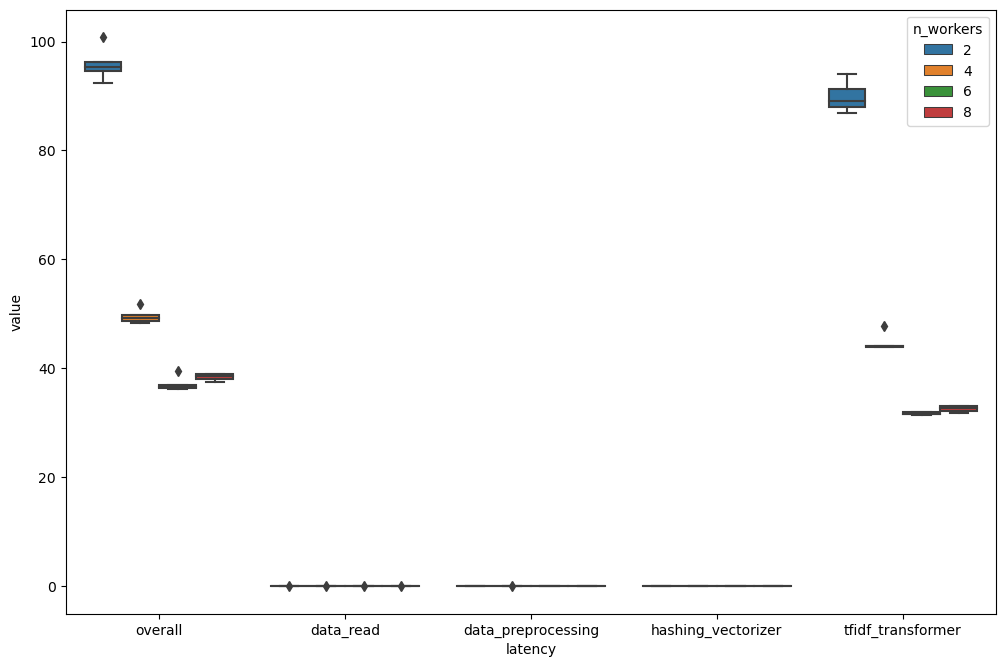

In [13]:
data, melt_data = visualize_data(result_path)        

In [14]:
groupby = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [15]:
groupby

Unnamed: 0                    overall                 data_read  \
                mean       std count       mean       std count      mean   
n_workers                                                                   
2                  2  1.581139     5  95.888180  3.102127     5  0.020495   
4                  7  1.581139     5  49.550530  1.397983     5  0.021843   
6                 12  1.581139     5  37.132006  1.383921     5  0.021829   
8                 17  1.581139     5  38.398050  0.657378     5  0.027137   

                          hashing_vectorizer  ... tfidf_transformer  \
                std count               mean  ...             count   
n_workers                                     ...                     
2          0.002437     5           0.003790  ...                 5   
4          0.003660     5           0.004023  ...                 5   
6          0.002773     5           0.003831  ...                 5   
8          0.010890     5           0.004023  ...                 5   

          data_preprocessing                     nrows            sample_run  \
                        mean       std count      mean  std count       mean   
n_workers                                                                      
2                   0.023397  0.001112     5  20725971  0.0     5          2   
4                   0.024636  0.002597     5  20725971  0.0     5          2   
6                   0.023183  0.000779     5  20725971  0.0     5          2   
8                   0.023591  0.001426     5  20725971  0.0     5          2   

                           
                std count  
n_workers                  
2          1.581139     5  
4          1.581139     5  
6          1.581139     5  
8          1.581139     5  

[4 rows x 24 columns]

In [16]:
client.close()
cluster.close()